In [1]:
# Importation des librairies



import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import prophet.plot as prophet_plot
prophet_plot.go = go
prophet_plot.make_subplots = make_subplots

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



/home/florian/TSM_AnsecData/projet_ansecdata/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
import pandas as pd

def build_flexible_timeseries_views(df):
    """
    df : DataFrame avec index DateTime déjà trié et colonnes numériques (Users, etc.)
    
    Retourne :
      df_daily_global  : toute la série, resamplée à 1 jour
      df_hourly_view   : partie horaire (1h + 10min agrégé à 1h), sans daily
      df_10min_view    : uniquement la partie 10min, sans hourly ni daily
    """
    df = df.sort_index().copy()
    
    # 1) Calcul des deltas temporels en secondes
    dt_seconds = df.index.to_series().diff().dt.total_seconds()

    # 2) Identifier début de chaque segment par fréquence
    #    1 jour = 86400s, 1h = 3600s, 10min = 600s
    start_hour = None
    start_10 = None
    
    if (dt_seconds == 3600).any():
        start_hour = df.index[dt_seconds == 3600].min()
    if (dt_seconds == 600).any():
        start_10 = df.index[dt_seconds == 600].min()
    
    print("Début segment horaire (1h) :", start_hour)
    print("Début segment 10min        :", start_10)
    
    # --- 1) Vue globale : toute la série resamplée à 1 jour ---
    df_daily_global = df.resample("1D").mean()
    
    # --- 2) Vue horaire : sans la partie daily ---
    # On commence à partir du début de l'horaire si disponible
    if start_hour is not None:
        df_no_daily = df.loc[start_hour:].copy()
        
        # On resample tout ça à 1h :
        # - la partie déjà horaire restera à 1h
        # - la partie 10min sera agrégée à 1h (moyenne)
        df_hourly_view = df_no_daily.resample("1H").mean()
    else:
        df_hourly_view = None
        print("Aucun segment horaire (1h) détecté, df_hourly_view = None")
    
    # --- 3) Vue 10min : uniquement la partie haute résolution ---
    if start_10 is not None:
        df_10min_view = df.loc[start_10:].copy()
        # On sécurise : resample exactement à 10min + moyenne
        df_10min_view = df_10min_view.resample("10min").mean()
    else:
        df_10min_view = None
        print(" Aucun segment 10min détecté, df_10min_view = None")
    
    return df_daily_global, df_hourly_view, df_10min_view


In [50]:

# Exemple avec ton df_weekly (index = DateTime)
df_weekly = pd.read_csv('Steam_users_10min_last_week.csv', sep=';')

df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])
df_weekly = df_weekly.sort_values('DateTime').set_index('DateTime')

# Nettoyage Users (en cas de virgules pour les milliers)
df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)

# Pipeline flexible
df_daily_global, df_hourly_view, df_10min_view = build_flexible_timeseries_views(df_weekly)

print("daily:", df_daily_global.shape)
print("hourly:", None if df_hourly_view is None else df_hourly_view.shape)
print("10min:", None if df_10min_view is None else df_10min_view.shape)

df = df_hourly_view.copy()

Début segment horaire (1h) : 2025-09-21 01:00:00
Début segment 10min        : 2025-10-14 14:10:00
daily: (7953, 3)
hourly: (734, 3)
10min: (1009, 3)


/tmp/ipykernel_24759/1273862674.py:41: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [51]:
print (df.head())

                          Users  Average Users    In-Game
DateTime                                                 
2025-09-21 01:00:00  26216934.0     32192507.0  7248543.0
2025-09-21 02:00:00  27170697.0     32130079.0  7624203.0
2025-09-21 03:00:00  27740645.0     32027431.0  7665237.0
2025-09-21 04:00:00  28177711.0     31889826.0  7712100.0
2025-09-21 05:00:00  28557973.0     31713172.0  7877300.0


In [52]:

import pandas as pd
import numpy as np
  
df = df.sort_index()

# Clipping éventuel
q_low, q_high = df['Users'].quantile([0.001, 0.999])
df['Users'] = df['Users'].clip(lower=q_low, upper=q_high)

# (Optionnel) log-transform
df['Users_log'] = np.log1p(df['Users'])

# Prophet (ds / y) – ici je pars sur Users "brut"
df_prophet = (
    df[['Users']]
    .reset_index()
    .rename(columns={df.index.name or 'index': 'ds', 'Users': 'y'})
)




In [68]:
use_log = False  # ou True si tu veux tester la version log

if use_log:
    df_prophet["y"] = np.log1p(df_prophet["y"])

from prophet import Prophet

m = Prophet(
    seasonality_mode=("additive" if use_log else "multiplicative"),
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_changepoints=30,
    changepoint_prior_scale=0.1,
    changepoint_range=0.9,
)

m.add_seasonality(name="monthly", period=30.5, fourier_order=3)

# fit
df_prophet["ds"] = df_prophet["ds"].dt.tz_localize(None)
m.fit(df_prophet)

# forecast
future = m.make_future_dataframe(periods=3, freq="D", include_history=True)
fcst = m.predict(future)

# Si tu avais entraîné en log, on repasse les prédictions en échelle normale
if use_log:
    for c in ["yhat", "yhat_lower", "yhat_upper"]:
        fcst[c] = np.expm1(fcst[c])


18:05:05 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing


In [69]:

# Horizon de prévision = 180 jours 
H = 3 
# Juste après model.predict()

future = m.make_future_dataframe(periods=H, freq="D", include_history=True)
forecast = m.predict(future)

print(future.tail())
print(fcst[["ds","yhat_lower","yhat","yhat_upper"]].tail())

# Vérif si NaN 
print("NaN rate:", fcst[["yhat_lower","yhat_upper"]].isna().mean())


hist_end = df_prophet["ds"].max()
print("Dernière date historique :", hist_end)
print("Premières dates de prévision :")
print(fcst.loc[fcst["ds"] > hist_end, ["ds","yhat"]].head())
print("Dernières dates de prévision :")
print(fcst.loc[fcst["ds"] > hist_end, ["ds","yhat"]].tail())



                     ds
732 2025-10-21 13:00:00
733 2025-10-21 14:00:00
734 2025-10-22 14:00:00
735 2025-10-23 14:00:00
736 2025-10-24 14:00:00
                     ds    yhat_lower          yhat    yhat_upper
732 2025-10-21 13:00:00  3.471965e+07  3.552445e+07  3.644875e+07
733 2025-10-21 14:00:00  3.541579e+07  3.629476e+07  3.715237e+07
734 2025-10-22 14:00:00  3.364729e+07  3.471357e+07  3.573252e+07
735 2025-10-23 14:00:00  3.083118e+07  3.274132e+07  3.455302e+07
736 2025-10-24 14:00:00  2.813512e+07  3.129942e+07  3.444110e+07
NaN rate: yhat_lower    0.0
yhat_upper    0.0
dtype: float64
Dernière date historique : 2025-10-21 14:00:00
Premières dates de prévision :
                     ds          yhat
734 2025-10-22 14:00:00  3.471357e+07
735 2025-10-23 14:00:00  3.274132e+07
736 2025-10-24 14:00:00  3.129942e+07
Dernières dates de prévision :
                     ds          yhat
734 2025-10-22 14:00:00  3.471357e+07
735 2025-10-23 14:00:00  3.274132e+07
736 2025-10-24 14:00:00 

In [14]:
# première visualisation (non interactive)
#fig2 = m_month.plot_components(forecast2) 
#fig1 = m_week.plot_components(forecast1) 



In [70]:

# Affichage avec cônes d’incertitude --
# 3.1 Série + prévision
import plotly.graph_objects as go
import pandas as pd
hist = df_prophet.copy()            
if use_log:
    hist["y"] = np.expm1(hist["y"])

fc = fcst[["ds","yhat","yhat_lower","yhat_upper"]].copy()


fig = go.Figure()

# historique 
fig.add_trace(go.Scatter(
    x=hist["ds"], y=hist["y"],
    mode="markers",
    name="Historique",
    opacity=0.6,
    marker=dict(size=4)
))

# intervalle
fig.add_trace(go.Scatter(
    x=pd.concat([fc["ds"], fc["ds"][::-1]]),
    y=pd.concat([fc["yhat_upper"], fc["yhat_lower"][::-1]]),
    fill="toself",
    name="Intervalle",
    line=dict(width=0),
    opacity=0.2
))

# yhat
fig.add_trace(go.Scatter(
    x=fc["ds"], y=fc["yhat"],
    mode="lines",
    name="Prévision"
))

fig.update_layout(
    title="Steam Users — Historique & Prévision (linéaire)",
    xaxis_title="Date",
    yaxis_title="Users"
)
fig.show()


In [71]:
# métriques et evaluation


# échelle 
df_eval = df_prophet[['ds','y']].copy()
fcst_eval = fcst[['ds','yhat']].copy()

if use_log:
    df_eval['y'] = np.expm1(df_eval['y'])
    fcst_eval['yhat'] = np.expm1(fcst_eval['yhat'])

# dates (normalisation au jour + suppression timezone)
df_eval['ds'] = pd.to_datetime(df_eval['ds']).dt.tz_localize(None).dt.normalize()
fcst_eval['ds'] = pd.to_datetime(fcst_eval['ds']).dt.tz_localize(None).dt.normalize()

# Merge 
merged = df_eval.merge(fcst_eval, on='ds', how='inner').dropna(subset=['y','yhat'])

print("Nombre de points utilisés pour l'évaluation:", len(merged))

# Extraction
y_true = merged['y'].values
y_pred = merged['yhat'].values

# Calcul des métriques
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

print("Métriques d'évaluation :")
print(f"MAE   : {mae:,.2f}")
print(f"RMSE  : {rmse:,.2f}")
print(f"R²    : {r2:,.4f}")
print(f"MAPE  : {mape:,.2f} %")




Nombre de points utilisés pour l'évaluation: 17458
Métriques d'évaluation :
MAE   : 5,228,711.64
RMSE  : 6,576,648.42
R²    : -0.7748
MAPE  : 17.70 %


<Axes: xlabel='ds'>

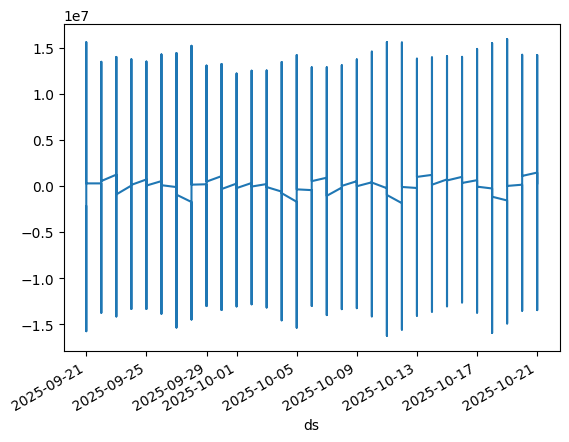

In [63]:
merged['residual'] = merged['y'] - merged['yhat']
merged.set_index('ds')['residual'].plot()


- MAE : En moyenne la prédiction se trompe d'env. 514'000 utilisateurs par jour
- RMSE : erreurs dans les pics/creux en moyenne de 948'000 utilisateurs 
- R2 : le modèle explique 99.26% de la variance -> très bon ajustement global
- MAPE : 7.2% l'erreur relative est de 6.71% donc bonne précision prédictive !




Si on veut aller plus loin on peux faire de l'hyperparameter tuning avec les tendances -> changepoint_prior_scale ou encore ajouter la saisonnalité journalière. 

On joit que juste avec dayly saisonnality = true on gagne 1% de MAPE env.

Je sais pas si on peut tune d'autres params...

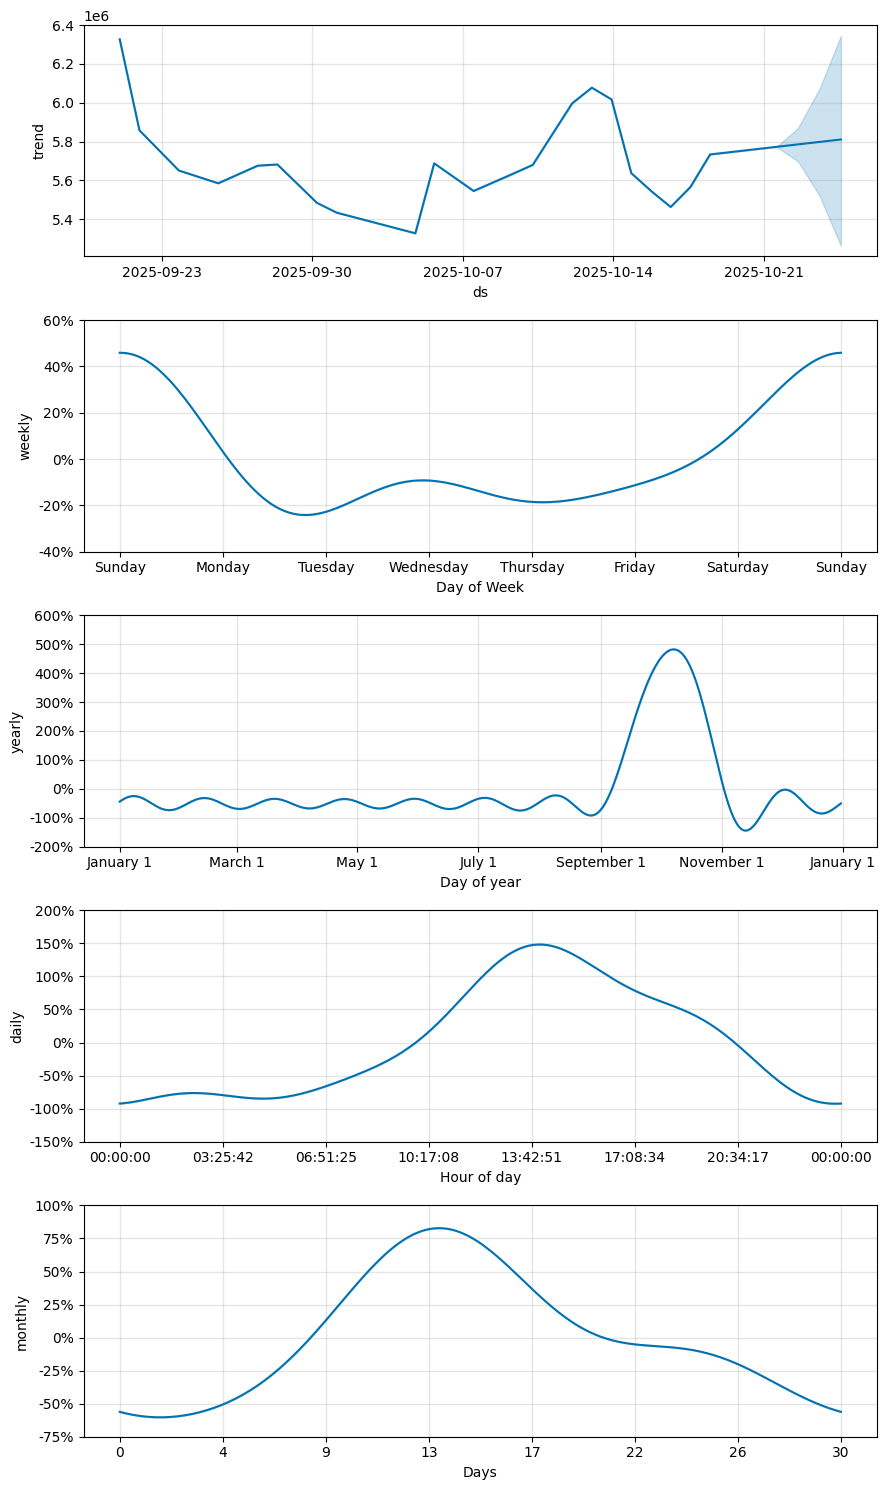

In [64]:
fig2 = m.plot_components(forecast)

Les modèles LSTM et Prophet ont tendance à extrapoler la tendance historique sur le long terme, ce qui peut conduire à des prévisions irréalistes. Avec Prophet, cette dérive peut être contrôlée explicitement via des fonctions de croissance logistique (cap/floor) et des priors sur la flexibilité de la tendance. Avec un LSTM, la stratégie consiste plutôt à stationnariser la série (en retirant la tendance et la saisonnalité), à entraîner le réseau sur les résidus, puis à réajouter une tendance maîtrisée, éventuellement saturée.

pour mettre un plafond avec prophet : 

df['y'] = users
df['ds'] = dates
df['cap'] = 40_000_000    # plafond (cap)
df['floor'] = 0           # optionnel

m = Prophet(growth='logistic')
m.fit(df)

future = m.make_future_dataframe(periods=365)
future['cap'] = 40_000_000
future['floor'] = 0
forecast = m.predict(future)

b) Rendre la tendance moins “agressive”

changepoint_prior_scale plus petit → la trend devient plus lisse et se stabilise plus vite.

changepoint_range < 1 → Prophet n’ajuste la tendace que sur la partie récente, ensuite ça reste presque droit.

m = Prophet(
    growth='linear',
    changepoint_prior_scale=0.05,  # plus petit = tendance moins flexible
)

